In [1]:
import os
import pandas as pd
import tensorflow as tf
from utils import Classifier, FashionMNIST, Trainer

2023-03-29 12:07:28.215026: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# MLP 

## Implement MLP from Scratch


In [2]:
class MLP(Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hiddens)) * sigma)
        self.b1 = tf.Variable(tf.zeros(num_hiddens))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hiddens, num_outputs)) * sigma)
        self.b2 = tf.Variable(tf.zeros(num_outputs))

    def forward(self, X):
        X = tf.reshape(X, (-1, self.num_inputs))
        H = relu(tf.matmul(X, self.W1) + self.b1)
        return tf.matmul(H, self.W2) + self.b2

In [3]:
def relu(X):
    return tf.math.maximum(X, 0)

### Training

the training loop for MLPs is exactly the same as for softmax regression.

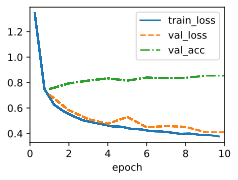

In [30]:
model = MLP(num_inputs=28*28, num_outputs=10, num_hiddens=256, lr=0.1)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

## Implement MLP with Tensorflow

In [6]:
class MLPKeras(Classifier):
    def __init__(self, num_hiddens, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([tf.keras.layers.Flatten(),
                                              tf.keras.layers.Dense(
                                                  num_hiddens, activation='relu'),
                                              tf.keras.layers.Dense(num_outputs)])

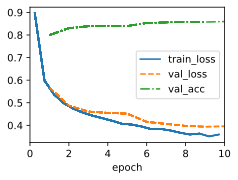

In [7]:
model = MLPKeras(num_hiddens=256, num_outputs=10, lr=0.1)
trainer.fit(model, data)

## Dropout
Apply dropout to a hidden layer, zeroing out each hidden unit with probability p, the result can be viewed as a network containing only a subset of the original neurons.

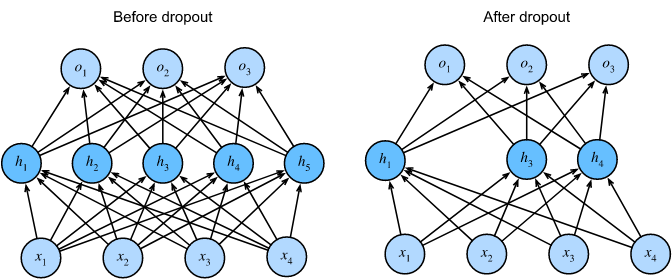

Typically, we disable dropout at test time. Given a trained model and a new example, we do not drop out any nodes and thus do not need to normalize.

In [8]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return tf.zeros_like(X)
    mask = tf.random.uniform(X.shape, minval=0, maxval=1) < 1 - dropout
    return tf.cast(mask, dtype=tf.float32) * X / (1.0-dropout)

In [21]:
class DropoutMLP(Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = tf.keras.layers.Dense(num_hiddens_1, activation='relu')
        self.lin2 = tf.keras.layers.Dense(num_hiddens_2, activation='relu')
        self.lin3 = tf.keras.layers.Dense(num_outputs)

    def forward(self, X):
        H1 = self.lin1(tf.reshape(X, (X.shape[0], -1)))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.lin2(H1)
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

In [22]:
hparams = {'num_outputs': 10, 'num_hiddens_1': 256,
           'num_hiddens_2': 256, 'dropout_1': 0.5,
           'dropout_2': 0.5, 'lr': 0.1}

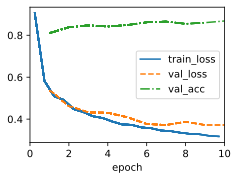

In [23]:
model = DropoutMLP(**hparams)
data = FashionMNIST(batch_size=256)
trainer = Trainer(max_epochs=10)
trainer.fit(model, data)

### Concise Implementation

In [24]:
class DropoutKeras(Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_hiddens_1, activation=tf.nn.relu),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(num_hiddens_2, activation=tf.nn.relu),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(num_outputs)
        ])

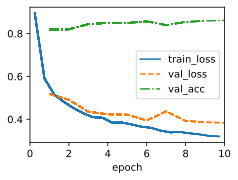

In [25]:
model = DropoutKeras(**hparams)
trainer.fit(model, data)

## Predicting House Prices on Kaggle 

In [2]:
from utils import *
from utils import download, extract, DataModule

### Read data

In [55]:
class KaggleHouse(DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(download(DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                                                  sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))

            self.raw_val = pd.read_csv(download(DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                                                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
        else:
            self.raw_train = train
            self.raw_val = val
        self.label = 'SalePrice'
        
    def preprocess(self):
        # remove ID and lable columns
        
        features = pd.concat((self.raw_train.drop(columns=['Id', label]),
                             self.raw_val.drop(columns=['Id']))
                             )
        # Standardize numerical columns
        numeric_features = features.dtypes[features.dtypes != 'object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / x.std())

        # Replace NAN numerical features by 0
        features[numeric_features] = features[numeric_features].fillna(0)

        # Replace discrete features by one-hot encoding
        features = pd.get_dummies(features, dummy_na=True)

        # Save preprocessed features
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()

    def get_dataloader(self, train):
        data = self.train if train else self.val
        if self.label not in data:
            return

        def get_tensor(x): return tf.constant(x.values, dtype=tf.float32)
        # Logarithm of prices
        tensors = (get_tensor(data.drop(columns=[self.label])),  # X
                   tf.reshape(tf.math.log(get_tensor(data[self.label])), (-1, 1)))  # Y

        return self.get_tensorloader(tensors, train)

In [56]:
train = pd.read_csv('./data/kaggle_house_pred_train.csv')
val = pd.read_csv('./data/kaggle_house_pred_test.csv')
data = KaggleHouse(batch_size=64, train=train, val=val)
data.raw_train.shape, data.raw_val.shape

((1460, 81), (1459, 80))

In [57]:
data.preprocess()
data.train.shape

(1460, 332)

### k-Fold Cross-Validation

In [58]:
from models import LinearRegressionKeras

In [59]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                    data.train.loc[idx]))
    return rets

In [61]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearRegressionKeras(lr)
        model.board.yscale = 'log'
        if i != 0:
            model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(model.board.data['val_loss'][-1].y)
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

In [77]:
trainer = Trainer(max_epochs=10)
data = KaggleHouse(batch_size=64, train=train, val=val)
data.preprocess()
data.train.shape, data.val.shape

((1460, 332), (1459, 331))

average validation log mse = 0.1758272221684456


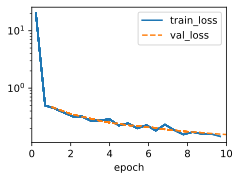

In [63]:
models = k_fold(trainer, data, k=5, lr = 0.01)

### Prediction 

In [79]:
# call forward() by model(val_data)
preds = [model(tf.constant(data.val.values, dtype=tf.float32)) 
         for model in models]

In [84]:
# Taking exponentiation of predictions in the logarithm scale
# Because label was logarized in `get_dataloader()`
ensemble_preds = tf.reduce_mean(tf.exp(tf.concat(preds, axis = 1)), axis = 1)

In [86]:
submission = pd.DataFrame({'Id': data.raw_val['Id'],
                           'SalePrice':ensemble_preds.numpy()})

In [87]:
submission

Id      SalePrice
0     1461   90665.703125
1     1462  532723.375000
2     1463  200459.750000
3     1464  264864.437500
4     1465  197512.093750
...    ...            ...
1454  2915   83462.625000
1455  2916   95980.398438
1456  2917  244630.546875
1457  2918   95019.398438
1458  2919  223185.031250

[1459 rows x 2 columns]